In [ ]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
import joblib
import os

from datetime import datetime

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Cell 2: Load data
X_train = pd.read_csv("../data/raw/X_train_G3tdtEn.csv")
y_train = pd.read_csv("../data/raw/Y_train_2_XPXJDyy.csv")
X_test = pd.read_csv("../data/raw/X_test_8skS2ey.csv")

/var/folders/3x/jrcv617s1gd_94yvvqdgzdrr0000gn/T/ipykernel_1418/377774935.py:2: DtypeWarning: Columns (21,22,23,24,69,70,71,72,93,94,95,96,97,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  X_train = pd.read_csv("../data/raw/X_train_G3tdtEn.csv")
/var/folders/3x/jrcv617s1gd_94yvvqdgzdrr0000gn/T/ipykernel_1418/377774935.py:4: DtypeWarning: Columns (20,21,22,23,24,68,69,70,71,72,92,93,94,95,96,97,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  X_test = pd.read_csv("../data/raw/X_test_8skS2ey.csv")


In [ ]:
# Cell 3: Format label
y_train = y_train["fraud_flag"]

In [ ]:
# Cell 4: Preprocessing pipeline
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64'] and col != 'ID']
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

In [ ]:
# Cell 5: Define models
models = {
    #"RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    #"XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42)
}

In [12]:
# Cell 6: Train and evaluate models
results = {}

# Split
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Corriger les types mélangés dans les colonnes catégorielles
X_train_part[cat_cols] = X_train_part[cat_cols].astype(str)
X_val_part[cat_cols] = X_val_part[cat_cols].astype(str)

# Entraînement des modèles
for name, model in models.items():
    clf = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    clf.fit(X_train_part, y_train_part)
    y_val_proba = clf.predict_proba(X_val_part)[:, 1]
    ap_score = average_precision_score(y_val_part, y_val_proba)
    results[name] = {
        "model": clf,
        "pr_auc": ap_score
    }
    print(f"{name} - Validation PR-AUC: {ap_score:.4f}")


RandomForest - Validation PR-AUC: 0.1900


/Users/drmohamed/Desktop/DS_Portfolio/detection-fraud-bnp/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:03:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Validation PR-AUC: 0.1866
[LightGBM] [Info] Number of positive: 1055, number of negative: 73177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5078
[LightGBM] [Info] Number of data points in the train set: 74232, number of used features: 1401
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014212 -> initscore=-4.239340
[LightGBM] [Info] Start training from score -4.239340


/Users/drmohamed/Desktop/DS_Portfolio/detection-fraud-bnp/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM - Validation PR-AUC: 0.1901


In [13]:
# Cell 7: Select best model
best_model_name = max(results, key=lambda x: results[x]["pr_auc"])
best_model = results[best_model_name]["model"]
print(f"\n✅ Best model selected: {best_model_name}")


✅ Best model selected: LightGBM


In [ ]:
# Cell 8: Retrain on full training set and predict

# Important : convertir les colonnes catégorielles en str
X_train[cat_cols] = X_train[cat_cols].astype(str)
X_test[cat_cols] = X_test[cat_cols].astype(str)

# Réentraîner le meilleur modèle sur tout l'ensemble d'entraînement
best_model.fit(X_train, y_train)

# Save final model
os.makedirs("output", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
joblib.dump(best_model, "../output/lgbm_model_final_{timestamp}.joblib")

# Prédiction
y_test_pred = best_model.predict_proba(X_test)[:, 1]

# Format de soumission
submission = pd.DataFrame({
    "index": range(len(X_test)),
    "ID": X_test["ID"],
    "fraud_flag": y_test_pred
})

# Sauvegarde
os.makedirs("../output", exist_ok=True)
expected_cols = ["index", "ID", "fraud_flag"]
assert submission.shape[1] == 3, "Le fichier de soumission doit avoir 3 colonnes : index, ID, fraud_flag"
assert submission.columns.tolist() == expected_cols, f"Les colonnes doivent être exactement {expected_cols}"
assert submission["fraud_flag"].between(0, 1).all(), "Toutes les probabilités doivent être entre 0 et 1"
assert submission["ID"].is_unique, "Chaque ID doit être unique"
assert (submission["index"] == range(len(submission))).all(), "La colonne index doit être une séquence de 0 à N-1"
print("Le format de soumission est valide.")

submission.to_csv("../output/submission.csv", index=False)
print("Submission saved to ../output/submission.csv")

[LightGBM] [Info] Number of positive: 1319, number of negative: 91471
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.539339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5815
[LightGBM] [Info] Number of data points in the train set: 92790, number of used features: 1638
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014215 -> initscore=-4.239148
[LightGBM] [Info] Start training from score -4.239148


/Users/drmohamed/Desktop/DS_Portfolio/detection-fraud-bnp/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Submission saved to ../output/submission.csv


/Users/drmohamed/Desktop/DS_Portfolio/detection-fraud-bnp/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


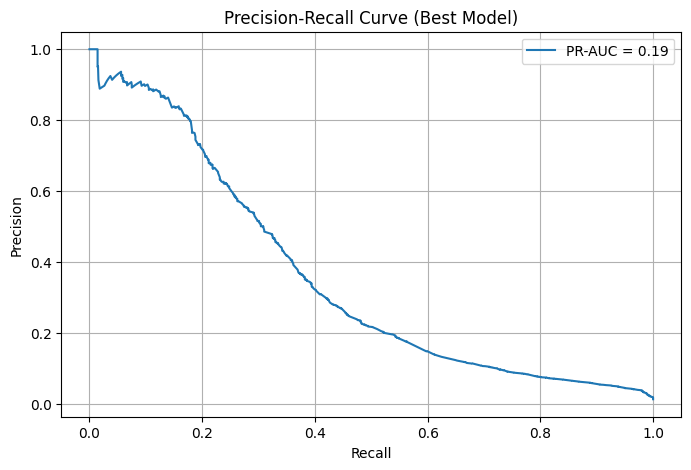

In [16]:
# Cell 9: Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_train, best_model.predict_proba(X_train)[:, 1])
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f"PR-AUC = {results[best_model_name]['pr_auc']:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Best Model)")
plt.legend()
plt.grid()
plt.show()